Plotting functions for comparing survival and recovery of groups of species within a single model scenario from the Salish Sea Atlantis Model

In [2]:
import os
import xarray as xr
import numpy as np
import geopandas as gpd
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

## Define scenario and control files

In [3]:
# Read in salish sea atlantis output files.
control_file = "/ocean/rlovindeer/MOAD/analysis-raisha/SSmodel_outputs/Scrubber_discharge_2019_02_control/outputSalishSea.nc"
scenario1_file = "/ocean/rlovindeer/MOAD/analysis-raisha/SSmodel_outputs/Scrubber_discharge_2019_02/outputSalishSea.nc"
scenario2_file = "/ocean/rlovindeer/MOAD/analysis-raisha/SSmodel_outputs/Scrubber_discharge_2019-2023_02/outputSalishSea.nc"
scenario3_file = "/ocean/rlovindeer/MOAD/analysis-raisha/SSmodel_outputs/Scrubber_discharge_2019-2029_02/outputSalishSea.nc"

control = xr.open_dataset(str(control_file), decode_cf=True)
scenario1 = xr.open_dataset(str(scenario1_file), decode_cf=True)
scenario2 = xr.open_dataset(str(scenario2_file), decode_cf=True)
scenario3 = xr.open_dataset(str(scenario3_file), decode_cf=True)

t = np.ma.filled(scenario1.variables['t'], np.nan)

# start and end time of data display, after burn-in
start = 101
end = t.size-1

time = t[start:end]

spill_start = np.datetime64('2019-01-01')
spill_end = np.datetime64('2019-12-31')


In [4]:
start = 112
end = 124

time = t[start:end]

spill_start = np.datetime64('2020-08-01')
spill_end = np.datetime64('2019-12-31')

## Dictionary of ecological groups

aged_groups = {
    'sharks','birds','mammals','fish','salmon','named_fish'
}

pelagic_groups = {
    'plankton','bacteria','sharks','birds','mammals','named_fish','salmon','fish','benth_feeders'
}

benthic_groups = {
    'benthos','shellfish'
}

In [132]:
cohorts = {
    'Benthopelagic':10, 'Small_Demersal_fish':10, 'Small_Flatfish':10, 'Small_pelagic_fish':7,
    'Chinook_salmon':5, 'Chum_salmon':5, 'Coho_salmon':5,'Pink_salmon':5, 'Sockeye_salmon':5, 
    'Other_salmonids':8,'Hatchery_Chinook_salmon':3,'Hatchery_Coho_salmon':3,'Hatchery_Sockeye_salmon':3,
    'Dogfish':10,'Ratfish':10,'Rockfish':10,'Sixgill':10,'Hake':10,
    'Harbor_porpoise':10, 'Harbor_seals':10,'Humpback_whales':10,
    'Large_Demersal_fish':10, 'Large_Flatfish' :10,'Lingcod' :10,
    'Orcas_resident':10, 'Orcas_transient':10,
    'Pacific_herring':10,'Pollock':10,'Sandlance':7, 
    'Seabird_gulls':10, 'Seabirds':10,'Sealions':10,'Skates':10,
}

sharks = {
    'dogfish':'Dogfish','ratfish':'Ratfish', 'sixgill':'Sixgill', 'skates':'Skates',
}

birds = {
    'seagulls':'Seabird_gulls', 'other seabirds':'Seabirds',
}

mammals = {
    'porpoises':'Harbor_porpoise', 'seals':'Harbor_seals', 'humpbacks':'Humpback_whales','sealions':'Sealions',
    'resident orcas':'Orcas_resident', 'transient orcas':'Orcas_transient',
}
    
fish = {
    'benthopelagic':'Benthopelagic', 'small pelagic':'Small_pelagic_fish', 'small demersal':'Small_Demersal_fish', 
    'large demersal':'Large_Demersal_fish', 'small flatfish':'Small_Flatfish', 'large flatfish':'Large_Flatfish',
}

named_fish = {
    'hake':'Hake','lingcod':'Lingcod', 'pollock':'Pollock', 'sandlance':'Sandlance', 
    'rockfish':'Rockfish', 'pacific herring':'Pacific_herring',
}

salmon = {
    'Chinook':'Chinook_salmon', 'Chum':'Chum_salmon', 'Coho':'Coho_salmon','Pink':'Pink_salmon', 'Sockeye':'Sockeye_salmon', 
    'Hatchery Chinook':'Hatchery_Chinook_salmon','Hatchery Coho':'Hatchery_Coho_salmon','Hatchery Sockeye':'Hatchery_Sockeye_salmon', 
    'Other salmonids':'Other_salmonids'
}

benthos = {
    'benthic grazers':'Benthic_grazer', 'filter feeders': 'Filter_feeder', 'macrobenthos':'Macrobenthos',  
    'macroalgae':'Macroalgae', 'seagrass':'Seagrass', 'sponges':'Sponges', 
}

benth_feeders = { #pelagic, i.e. have > 1 depth level
    'benthic carnivores':'Benthic_Carniv', 'deposit feeders':'Deposit_Feeder', 'meiobenthos':'Meiobenth',
}
    
shellfish = {
    'bivalves':'Bivalves', 'crabs':'Crabs', 'dungeness crabs':'Dungeness_crabs',
}

plankton = {
    'carnivorous zooplankton':'Carniv_Zoo', 'gelatinous zooplantkon':'Gelat_Zoo', 'microzooplankton':'MicroZoo',
    'mesozooplankton':'Zoo', 'diatoms':'Diatom', 'picophytoplankton':'PicoPhytopl', 'squid':'Squid', 'prawn': 'Prawn',
}

bacteria = {
    'pelagic labile detritus':'Lab_Det', 'pelagic refractory detritus':'Ref_Det', 'pelagic bacteria':'Pelag_Bact',
    'sedimentary labile detritus':'Lab_Det', 'sedimentary refractory detritus':'Ref_Det', 'sedimentary bacteria': 'Sed_Bact',
}

In [44]:
birds

{'seagulls': 'Seabird_gulls', 'other seabirds': 'Seabirds'}

## Group plotting functions

- plot_benthos(group)
- plot_pelagic(group)
- plot_cohorts(group)

In [53]:
def plot_benthic(group, scenario): # benthos, shellfish

    # Plot variables
    label_size = 11
    font_size = 12
    line_width = 2
    y_min = 0.8
    y_max = 1.2

    fig, ax = plt.subplots(figsize = (14,3))
    ax.tick_params(labelsize=label_size)
    ax.set_ylabel('scenario:control')
    ax.set_title('Biomass of benthic groups across all boxes in Salish Sea Atlantis', fontsize = font_size)
    ax.set_ylim(y_min,  y_max)

    for species in group:
        benthic_oiled = np.ma.filled(scenario.variables[group[species] + '_N'][start:end,:], np.nan) # tonnes
        benthic_control = np.ma.filled(control.variables[group[species] + '_N'][start:end,:], np.nan)
        ratio = benthic_oiled.sum(axis=1) / benthic_control.sum(axis=1) 
        control_ratio = benthic_control.sum(axis=1)  / benthic_control.sum(axis=1) 
        ax.plot(time, ratio, linewidth = 2)
    
    ax.legend(group) #, loc='center left')
    ax.plot(time, control_ratio, 'k',linewidth = 2)
    ax.plot(spill_start, 1, 'ro', alpha=0.5)
    #ax.plot([spill_end, spill_end], [y_min, y_max], 'r',alpha=0.1)
    return fig, ax

In [54]:
def plot_benthic_box(group, scenario, box_number): # benthos, shellfish

    # Plot variables
    label_size = 11
    font_size = 12
    line_width = 2
    y_min = 0.8
    y_max = 1.2

    fig, ax = plt.subplots(figsize = (14,3))
    ax.tick_params(labelsize=label_size)
    ax.set_ylabel('scenario:control')
    ax.set_title('Biomass of benthic groups across all boxes in Salish Sea Atlantis', fontsize = font_size)
    ax.set_ylim(y_min, y_max)

    for species in group:
        benthic_oiled = scenario.variables[group[species] + '_N'][start:end,box_number] # tonnes
        benthic_control = control.variables[group[species] + '_N'][start:end,box_number]
        ratio = benthic_oiled / benthic_control
        control_ratio = benthic_control / benthic_control
        ax.plot(time, ratio, linewidth = 2)
    
    ax.legend(group, loc='center left')
    ax.plot(time, control_ratio, 'k',linewidth = 2)
    ax.plot(spill_start, 1, 'ro', alpha=0.5)
    #ax.plot([spill_end, spill_end], [y_min, y_max], 'r',alpha=0.1)
    return fig, ax

In [90]:
def plot_bacteria(scenario):
    
    # Plot variables
    label_size = 11
    font_size = 12
    line_width = 2
    # y_min = 0.8
    # y_max = 1.2

    fig, ax = plt.subplots(figsize = (14,3))
    ax.tick_params(labelsize=label_size)
    ax.set_ylabel('scenario:control')
    ax.set_title('Biomass of groups in sediment in Salish Sea Atlantis', fontsize = font_size)
    # ax.set_ylim([y_min, y_max])

    for species in bacteria:
        if "pelagic" in species:
            bact_oiled = np.ma.filled(scenario.variables[bacteria[species] + '_N'][start:end,:,0:5], np.nan) # tonnes, take only water column layers
            bact_control = np.ma.filled(control.variables[bacteria[species] + '_N'][start:end,:,0:5,], np.nan)
            b_oiled = bact_oiled.sum(axis=2)
            b_control = bact_control.sum(axis=2)
        else:
            b_oiled = np.ma.filled(scenario.variables[bacteria[species] + '_N'][start:end,:,6], np.nan) # tonnes, take only sediment layer
            b_control = np.ma.filled(control.variables[bacteria[species] + '_N'][start:end,:,6], np.nan)
        
        ratio = b_oiled.sum(axis=1) / b_control.sum(axis=1) 
        control_ratio = b_control.sum(axis=1) / b_control.sum(axis=1)
        ax.plot(time, ratio, linewidth = 2)
    
    ax.legend(bacteria, loc='center left')
    ax.plot(time, control_ratio, 'k',linewidth = 2)
    ax.plot(spill_start, 1, 'ro', alpha=0.5)
    #ax.plot([spill_end, spill_end], [y_min, y_max], 'r',alpha=0.1)
    return fig, ax

In [121]:
def plot_bacteria_test(scenario):
    
    # Plot variables
    label_size = 11
    font_size = 12
    line_width = 2
    # y_min = 0.8
    # y_max = 1.2

    fig, ax = plt.subplots(figsize = (14,3))
    ax.tick_params(labelsize=label_size)
    ax.set_ylabel('scenario:control')
    ax.set_title('Biomass of groups in sediment in Salish Sea Atlantis', fontsize = font_size)
    # ax.set_ylim([y_min, y_max])

    for species in bacteria:
        if "sedimentary" in species:
            b_oiled = np.ma.filled(scenario.variables[bacteria[species] + '_N'][start:end,:,6], np.nan) # tonnes, take only sediment layer
            b_control = np.ma.filled(control.variables[bacteria[species] + '_N'][start:end,:,6], np.nan)
        else:
            bact_oiled = np.ma.filled(scenario.variables[bacteria[species] + '_N'][start:end,:,0:5], np.nan) # tonnes, take only water column layers
            bact_control = np.ma.filled(control.variables[bacteria[species] + '_N'][start:end,:,0:5,], np.nan)
            b_oiled = bact_oiled.sum(axis=2)
            b_control = bact_control.sum(axis=2)
        
        ratio = b_oiled.sum(axis=1) / b_control.sum(axis=1) 
        control_ratio = b_control.sum(axis=1) / b_control.sum(axis=1)
        ax.plot(time, ratio, linewidth = 2)
    
    ax.legend(bacteria, loc='center left')
    ax.plot(time, control_ratio, 'k',linewidth = 2)
    ax.plot(spill_start, 1, 'ro', alpha=0.5)
    #ax.plot([spill_end, spill_end], [y_min, y_max], 'r',alpha=0.1)
    return fig, ax

In [96]:
def plot_bacteria_box(scenario, box_number): #bacteria, plankton
    
    # Plot variables
    label_size = 11
    font_size = 12
    line_width = 2
    # y_min = 0.8
    # y_max = 1.2

    fig, ax = plt.subplots(figsize = (14,3))
    ax.tick_params(labelsize=label_size)
    ax.set_ylabel('scenario:control')
    ax.set_title('Biomass of groups in sediment in Salish Sea Atlantis', fontsize = font_size)
    # ax.set_ylim([y_min, y_max])

    for species in bacteria:
        if "pelagic" in species:
            bact_oiled = np.ma.filled(scenario.variables[bacteria[species] + '_N'][start:end,box_number,0:5], np.nan) # tonnes, take only water column layers
            bact_control = np.ma.filled(control.variables[bacteria[species] + '_N'][start:end,box_number,0:5,], np.nan)
            b_oiled = bact_oiled.sum(axis=1)
            b_control = bact_control.sum(axis=1)
        else:
            b_oiled = np.ma.filled(scenario.variables[bacteria[species] + '_N'][start:end,box_number,6], np.nan) # tonnes, take only sediment layer
            b_control = np.ma.filled(control.variables[bacteria[species] + '_N'][start:end,box_number,6], np.nan)
        
        ratio = b_oiled / b_control
        control_ratio = b_control / b_control
        ax.plot(time, ratio, linewidth = 2)
    
    ax.legend(bacteria, loc='center left')
    ax.plot(time, control_ratio, 'k',linewidth = 2)
    ax.plot(spill_start, 1, 'ro', alpha=0.5)
    #ax.plot([spill_end, spill_end], [y_min, y_max], 'r',alpha=0.1)
    return fig, ax

In [124]:
def plot_bacteria_box_test(scenario, box_number): #bacteria, plankton
    
    # Plot variables
    label_size = 11
    font_size = 12
    line_width = 2
    # y_min = 0.8
    # y_max = 1.2

    fig, ax = plt.subplots(figsize = (14,3))
    ax.tick_params(labelsize=label_size)
    ax.set_ylabel('scenario:control')
    ax.set_title('Biomass of groups in sediment in Salish Sea Atlantis', fontsize = font_size)
    # ax.set_ylim([y_min, y_max])

    for species in bacteria:
        if "sedimentary" in species:
            b_oiled = np.ma.filled(scenario.variables[bacteria[species] + '_N'][start:end,box_number,6], np.nan) # tonnes, take only sediment layer
            b_control = np.ma.filled(control.variables[bacteria[species] + '_N'][start:end,box_number,6], np.nan)
        else:
            bact_oiled = np.ma.filled(scenario.variables[bacteria[species] + '_N'][start:end,box_number,0:5], np.nan) # tonnes, take only water column layers
            bact_control = np.ma.filled(control.variables[bacteria[species] + '_N'][start:end,box_number,0:5,], np.nan)
            b_oiled = bact_oiled.sum(axis=1)
            b_control = bact_control.sum(axis=1)
        ratio = b_oiled / b_control
        control_ratio = b_control / b_control
        ax.plot(time, ratio, linewidth = 2)
    
    ax.legend(bacteria, loc='center left')
    ax.plot(time, control_ratio, 'k',linewidth = 2)
    ax.plot(spill_start, 1, 'ro', alpha=0.5)
    #ax.plot([spill_end, spill_end], [y_min, y_max], 'r',alpha=0.1)
    return fig, ax

In [98]:
def plot_sediment(group, scenario): #bacteria, plankton
    
    # Plot variables
    label_size = 11
    font_size = 12
    line_width = 2
    y_min = 0.5
    y_max = 1.5

    fig, ax = plt.subplots(figsize = (14,3))
    ax.tick_params(labelsize=label_size)
    ax.set_ylabel('scenario:control')
    ax.set_title('Biomass of groups in sediment in Salish Sea Atlantis', fontsize = font_size)
    #ax.set_ylim([y_min, y_max])

    for species in group:
        sed_oiled = np.ma.filled(scenario.variables[group[species] + '_N'][start:end,:,6], np.nan) # tonnes
        sed_control = np.ma.filled(control.variables[group[species] + '_N'][start:end,:,6], np.nan)
        s_oiled = sed_oiled.sum(axis=1)
        s_control = sed_control.sum(axis=1)
        ratio = s_oiled / s_control
        control_ratio = s_control / s_control
        ax.plot(time, ratio, linewidth = 2)
    
    ax.legend(group, loc='center left')
    ax.plot(time, control_ratio, 'k',linewidth = 2)
    ax.plot(spill_start, 1, 'ro', alpha=0.5)
    #ax.plot([spill_end, spill_end], [y_min, y_max], 'r',alpha=0.1)
    return fig, ax

In [99]:
def plot_sediment_box(group, scenario, box_number): #bacteria, plankton
    
    # Plot variables
    label_size = 11
    font_size = 12
    line_width = 2
    y_min = 0.5
    y_max = 1.5

    fig, ax = plt.subplots(figsize = (14,3))
    ax.tick_params(labelsize=label_size)
    ax.set_ylabel('scenario:control')
    ax.set_title('Biomass of groups in sediment in Salish Sea Atlantis box ' + str(box_number), fontsize = font_size)
    #ax.set_ylim([y_min, y_max])

    for species in group:
        s_oiled = np.ma.filled(scenario.variables[group[species] + '_N'][start:end,box_number,6], np.nan) # tonnes
        s_control = np.ma.filled(control.variables[group[species] + '_N'][start:end,box_number,6], np.nan)
        ratio = s_oiled / s_control
        control_ratio = s_control / s_control
        ax.plot(time, ratio, linewidth = 2)
    
    ax.legend(group, loc='center left')
    ax.plot(time, control_ratio, 'k',linewidth = 2)
    ax.plot(spill_start, 1, 'ro', alpha=0.5)
    #ax.plot([spill_end, spill_end], [y_min, y_max], 'r',alpha=0.1)
    return fig, ax

In [100]:
def plot_pelagic(group, scenario): #bacteria, plankton
    
    # Plot variables
    label_size = 11
    font_size = 12
    line_width = 2
    y_min = 0.8
    y_max = 1.2

    fig, ax = plt.subplots(figsize = (14,3))
    ax.tick_params(labelsize=label_size)
    ax.set_ylabel('scenario:control')
    ax.set_title('Biomass of pelagic groups across all boxes in Salish Sea Atlantis', fontsize = font_size)
    ax.set_ylim([y_min, y_max])

    for species in group:
        pelagic_oiled = np.ma.filled(scenario.variables[group[species] + '_N'][start:end,:,0:5], np.nan) # tonnes, take only water column layers
        pelagic_control = np.ma.filled(control.variables[group[species] + '_N'][start:end,:,0:5], np.nan)
        p_oiled = pelagic_oiled.sum(axis=1)
        p_control = pelagic_control.sum(axis=1)
        ratio = p_oiled.sum(axis=1) / p_control.sum(axis=1) 
        control_ratio = p_control.sum(axis=1) / p_control.sum(axis=1)
        ax.plot(time, ratio, linewidth = 2)
    
    ax.legend(group, loc='center left')
    ax.plot(time, control_ratio, 'k',linewidth = 2)
    ax.plot(spill_start, 1, 'ro', alpha=0.5)
    #ax.plot([spill_end, spill_end], [y_min, y_max], 'r',alpha=0.1)
    return fig, ax

In [130]:
def plot_pelagic_box(group, scenario, box_number): #bacteria, plankton
    
    # Plot variables
    label_size = 11
    font_size = 12
    line_width = 2
    y_min = 0.5
    y_max = 1.5

    fig, ax = plt.subplots(figsize = (14,3))
    ax.tick_params(labelsize=label_size)
    ax.set_ylabel('scenario:control')
    ax.set_title('Biomass of pelagic groups in Salish Sea Atlantis box ' + str(box_number), fontsize = font_size)
    #ax.set_ylim([y_min, y_max])

    for species in group:
        pelagic_oiled = np.ma.filled(scenario.variables[group[species] + '_N'][start:end,box_number,0:5], np.nan) # tonnes
        pelagic_control = np.ma.filled(control.variables[group[species] + '_N'][start:end,box_number,0:5], np.nan)
        p_oiled = pelagic_oiled.sum(axis=1)
        p_control = pelagic_control.sum(axis=1)
        ratio = p_oiled / p_control
        control_ratio = p_control / p_control
        ax.plot(time, ratio, linewidth = 2)
    
    ax.legend(group, loc='center left')
    ax.plot(time, control_ratio, 'k',linewidth = 2)
    ax.plot(spill_start, 1, 'ro', alpha=0.5)
    #ax.plot([spill_end, spill_end], [y_min, y_max], 'r',alpha=0.1)
    return fig, ax

In [49]:
def plot_cohorts(group, scenario):

    # Plot variables
    label_size = 11
    font_size = 12
    line_width = 2
    y_min = 0.9
    y_max = 1.1

    for species in group:
        fig, ax = plt.subplots(3,1, figsize = (14,9), sharex='all')
        ax[0].set_title(species + ' cohort numbers', fontsize = font_size)
        ax[0].set_ylabel('scenario : control')
        ax[0].tick_params(labelsize=label_size)
        ax[0].set_ylim([y_min, y_max])

        ax[1].set_title(species + ' cohort structural nitrogen (bone size)', fontsize = font_size)
        ax[1].set_ylabel('scenario : control')
        ax[1].tick_params(labelsize=label_size)
        ax[1].set_ylim([y_min, y_max])

        ax[2].set_title(species + ' cohort reserve nitrogen (fatty tissue)', fontsize = font_size)
        ax[2].set_ylabel('scenario : control')
        ax[2].tick_params(labelsize=label_size)
        ax[2].set_ylim([y_min, y_max])

        numCohorts = cohorts[group[species]]
        cohort_names = []

        for cohort_num in range (1, numCohorts+1):

            new_species = group[species] + str(cohort_num)
            cohort_names.append(cohort_num)
        
            o1_numbers = np.ma.filled(scenario.variables[new_species + '_Nums'][:,:,:], np.nan)
            o1_structuralN = np.ma.filled(scenario.variables[new_species +'_StructN'][:,:,:], np.nan)
            o1_reservedN = np.ma.filled(scenario.variables[new_species +'_ResN'][:,:,:], np.nan)

            c1_numbers = np.ma.filled(control.variables[new_species + '_Nums'][:,:,:], np.nan)
            c1_structuralN = np.ma.filled(control.variables[new_species +'_StructN'][:,:,:], np.nan)
            c1_reservedN = np.ma.filled(control.variables[new_species +'_ResN'][:,:,:], np.nan)

            o2_numbers = o1_numbers.sum(axis=2)
            o2_structuralN = o1_structuralN.sum(axis=2)
            o2_reservedN = o1_reservedN.sum(axis=2)

            c2_numbers = c1_numbers.sum(axis=2)
            c2_structuralN = c1_structuralN.sum(axis=2)
            c2_reservedN = c1_reservedN.sum(axis=2)

            numbers = o2_numbers.sum(axis=1) / c2_numbers.sum(axis=1)
            structuralN = o2_structuralN.sum(axis=1) / c2_structuralN.sum(axis=1)
            reservedN = o2_reservedN.sum(axis=1) / c2_reservedN.sum(axis=1)
            control_ratio = c2_reservedN.sum(axis=1) / c2_reservedN.sum(axis=1)

            ax[0].plot(time, numbers[start:end], linewidth = line_width)
            ax[1].plot(time, structuralN[start:end],linewidth = line_width)
            ax[2].plot(time, reservedN[start:end],linewidth = line_width)

        ax[0].legend(cohort_names, loc='center left')
        ax[0].plot(time, control_ratio[start:end], 'k',linewidth = 2)
        ax[0].plot(spill_start, 1, 'ro', alpha=0.5)
        #ax[0].plot([spill_start, spill_start], [y_min, y_max], 'r', alpha=0.1)
        #ax[0].plot([spill_end, spill_end], [y_min, y_max], 'r',alpha=0.1)

        ax[1].plot(time, control_ratio[start:end], 'k',linewidth = 2)
        ax[1].plot(spill_start, 1, 'ro', alpha=0.5)
        #ax[1].plot([spill_start, spill_start], [y_min, y_max], 'r', alpha=0.1)
        #ax[1].plot([spill_end, spill_end], [y_min, y_max], 'r',alpha=0.1)

        ax[2].plot(time, control_ratio[start:end], 'k',linewidth = 2)
        ax[2].plot(spill_start, 1, 'ro', alpha=0.5)
        #ax[2].plot([spill_start, spill_start], [y_min, y_max], 'r', alpha=0.1)
        #ax[2].plot([spill_end, spill_end], [y_min, y_max], 'r',alpha=0.1)

    return fig, ax
    

In [11]:
def plot_pelagic_pah_box(group, pah, scenario, box_number):

# Plot variables
    label_size = 11
    font_size = 12
    line_width = 2

    fig, ax = plt.subplots(figsize = (14,3))
    ax.tick_params(labelsize=label_size)
    ax.set_ylabel('mgPAH')
    ax.set_title(pah + 'in pelagic groups in Salish Sea Atlantis box ' + str(box_number), fontsize = font_size)

    for species in group:
        pelagic_oiled = scenario.variables[group[species] + '_' + pah][start:end,box_number,:]
        p_oiled = pelagic_oiled.sum(axis=1)
        ax.plot(time, p_oiled, linewidth = 2)
    
    ax.legend(group, loc='center left')
    return fig, ax

## Plotting group ratios

### Across whole model

(<Figure size 1008x216 with 1 Axes>,
 <AxesSubplot:title={'center':'Biomass of pelagic groups across all boxes in Salish Sea Atlantis'}, ylabel='scenario:control'>)

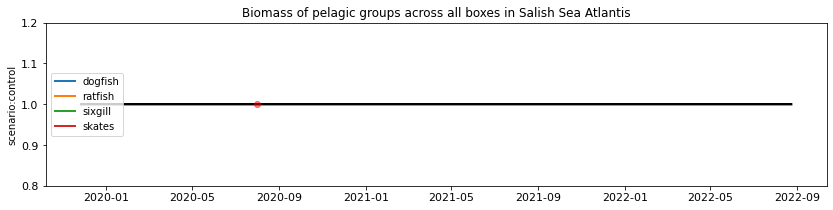

In [102]:
plot_pelagic(sharks, scenario1)

(<Figure size 1008x216 with 1 Axes>,
 <AxesSubplot:title={'center':'Biomass of pelagic groups across all boxes in Salish Sea Atlantis'}, ylabel='scenario:control'>)

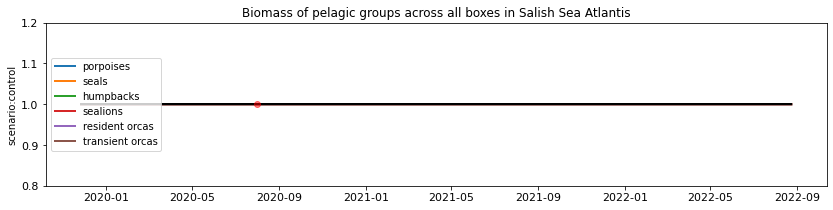

In [103]:
plot_pelagic(mammals, scenario1)

/tmp/ipykernel_3863286/385269390.py:21: RuntimeWarning: invalid value encountered in true_divide
  ratio = p_oiled.sum(axis=1) / p_control.sum(axis=1)
/tmp/ipykernel_3863286/385269390.py:22: RuntimeWarning: invalid value encountered in true_divide
  control_ratio = p_control.sum(axis=1) / p_control.sum(axis=1)


(<Figure size 1008x216 with 1 Axes>,
 <AxesSubplot:title={'center':'Biomass of pelagic groups across all boxes in Salish Sea Atlantis'}, ylabel='scenario:control'>)

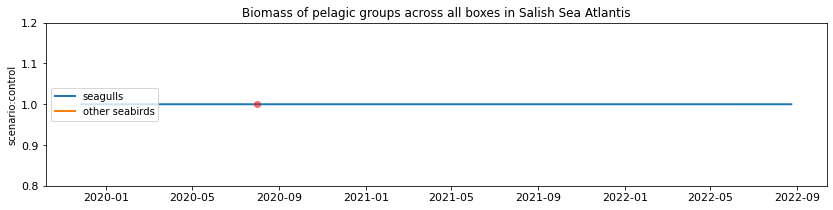

In [104]:
plot_pelagic(birds, scenario1)

(<Figure size 1008x216 with 1 Axes>,
 <AxesSubplot:title={'center':'Biomass of pelagic groups across all boxes in Salish Sea Atlantis'}, ylabel='scenario:control'>)

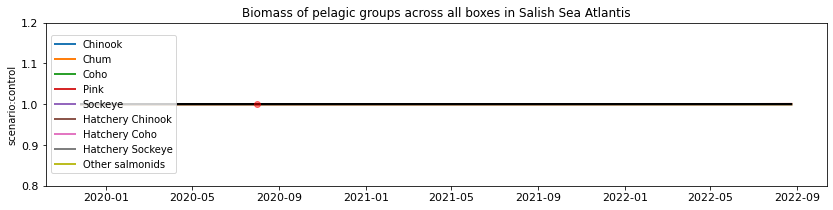

In [105]:
plot_pelagic(salmon, scenario1)

(<Figure size 1008x216 with 1 Axes>,
 <AxesSubplot:title={'center':'Biomass of pelagic groups across all boxes in Salish Sea Atlantis'}, ylabel='scenario:control'>)

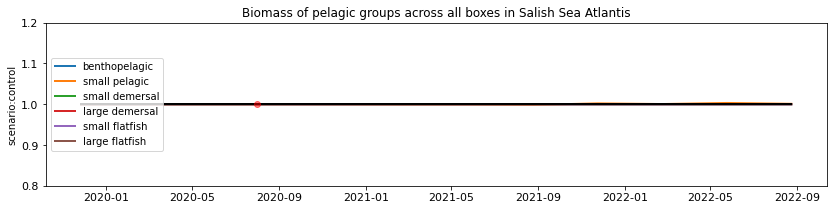

In [106]:
plot_pelagic(fish, scenario1)

(<Figure size 1008x216 with 1 Axes>,
 <AxesSubplot:title={'center':'Biomass of pelagic groups across all boxes in Salish Sea Atlantis'}, ylabel='scenario:control'>)

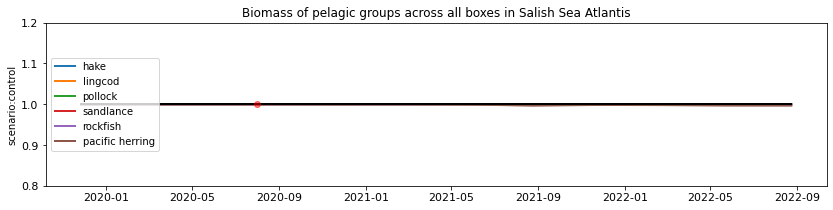

In [107]:
plot_pelagic(named_fish, scenario1)

(<Figure size 1008x216 with 1 Axes>,
 <AxesSubplot:title={'center':'Biomass of pelagic groups across all boxes in Salish Sea Atlantis'}, ylabel='scenario:control'>)

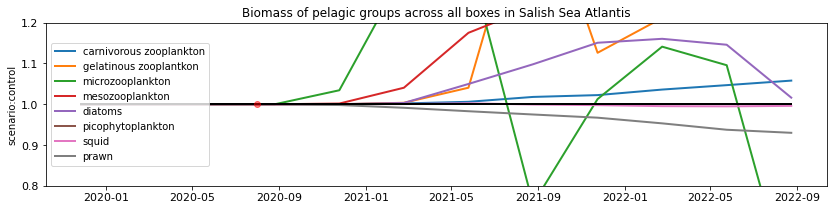

In [108]:
plot_pelagic(plankton, scenario1)

(<Figure size 1008x216 with 1 Axes>,
 <AxesSubplot:title={'center':'Biomass of groups in sediment in Salish Sea Atlantis'}, ylabel='scenario:control'>)

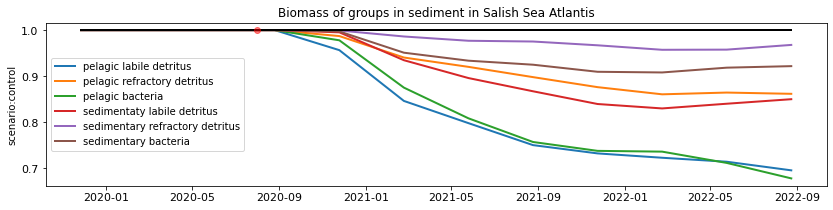

In [109]:
plot_bacteria(scenario1)

(<Figure size 1008x216 with 1 Axes>,
 <AxesSubplot:title={'center':'Biomass of groups in sediment in Salish Sea Atlantis'}, ylabel='scenario:control'>)

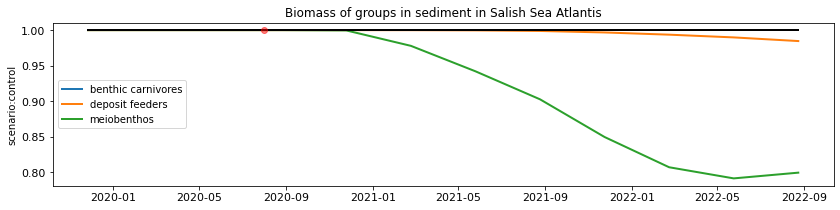

In [111]:
plot_sediment(benth_feeders, scenario1)

(<Figure size 1008x216 with 1 Axes>,
 <AxesSubplot:title={'center':'Biomass of benthic groups across all boxes in Salish Sea Atlantis'}, ylabel='scenario:control'>)

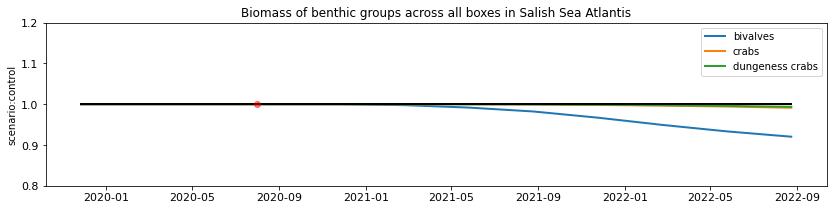

In [112]:
plot_benthic(shellfish, scenario1)

(<Figure size 1008x216 with 1 Axes>,
 <AxesSubplot:title={'center':'Biomass of benthic groups across all boxes in Salish Sea Atlantis'}, ylabel='scenario:control'>)

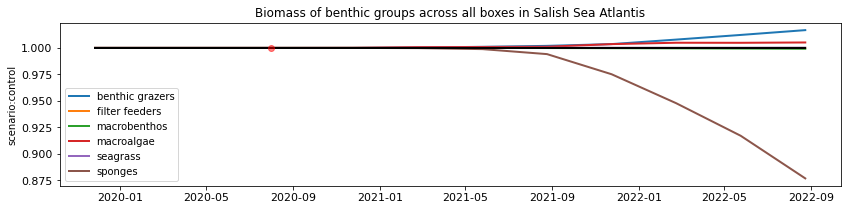

In [22]:
plot_benthic(benthos, scenario1)

### Individual boxes

(<Figure size 1008x216 with 1 Axes>,
 <AxesSubplot:title={'center':'Biomass of benthic groups across all boxes in Salish Sea Atlantis'}, ylabel='scenario:control'>)

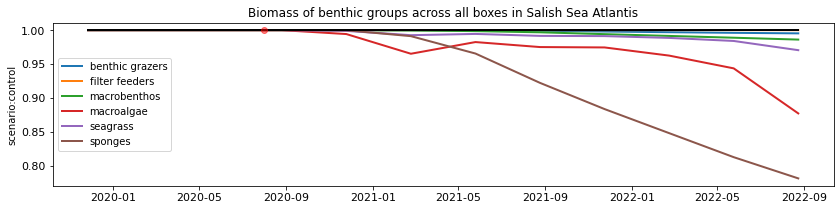

In [23]:
plot_benthic_box(benthos, scenario1, 5)

(<Figure size 1008x216 with 1 Axes>,
 <AxesSubplot:title={'center':'Biomass of benthic groups across all boxes in Salish Sea Atlantis'}, ylabel='scenario:control'>)

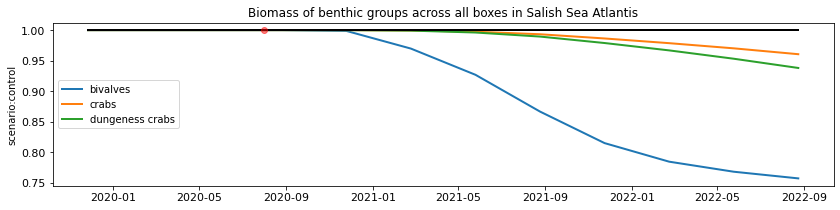

In [24]:
plot_benthic_box(shellfish, scenario1, 5)

(<Figure size 1008x216 with 1 Axes>,
 <AxesSubplot:title={'center':'Biomass of groups in sediment in Salish Sea Atlantis box 5'}, ylabel='scenario:control'>)

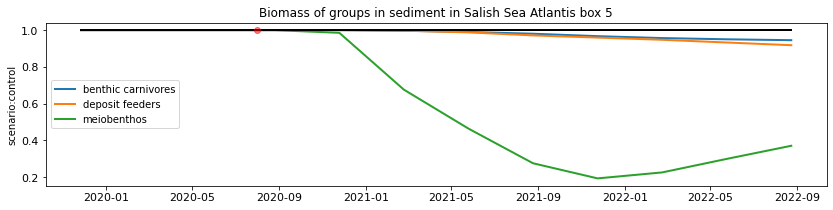

In [114]:
plot_sediment_box(benth_feeders, scenario1, 5)

(<Figure size 1008x216 with 1 Axes>,
 <AxesSubplot:title={'center':'Biomass of groups in sediment in Salish Sea Atlantis'}, ylabel='scenario:control'>)

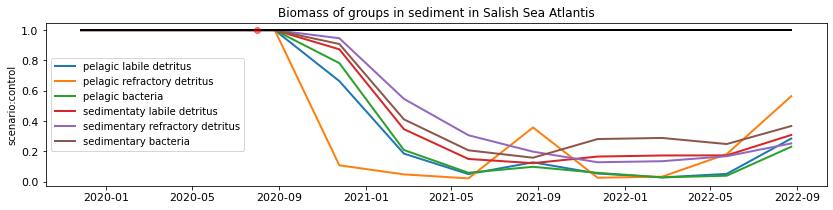

In [97]:
plot_bacteria_box(scenario1, 5)

(<Figure size 1008x216 with 1 Axes>,
 <AxesSubplot:title={'center':'Biomass of groups in sediment in Salish Sea Atlantis'}, ylabel='scenario:control'>)

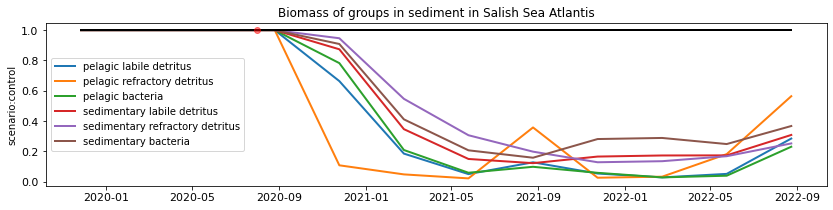

In [127]:
plot_bacteria_box_test(scenario1, 5)

(<Figure size 1008x216 with 1 Axes>,
 <AxesSubplot:title={'center':'Biomass of pelagic groups in Salish Sea Atlantis box 5'}, ylabel='scenario:control'>)

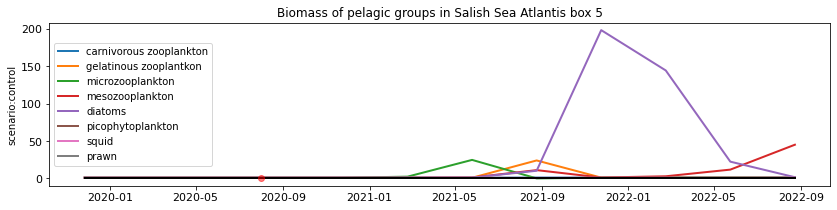

In [135]:
plot_pelagic_box(plankton, scenario1, 5)

(<Figure size 1008x216 with 1 Axes>,
 <AxesSubplot:title={'center':'Biomass of groups in sediment in Salish Sea Atlantis box 5'}, ylabel='scenario:control'>)

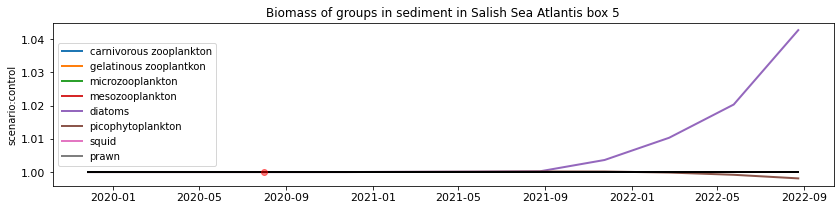

In [136]:
plot_sediment_box(plankton, scenario1, 5)

(<Figure size 1008x216 with 1 Axes>,
 <AxesSubplot:title={'center':'Biomass of pelagic groups in Salish Sea Atlantis box 5'}, ylabel='scenario:control'>)

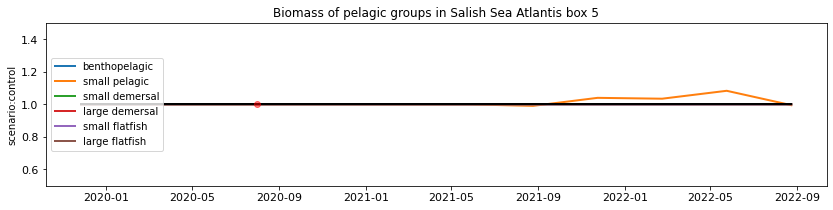

In [118]:
plot_pelagic_box(fish, scenario1, 5)

(<Figure size 1008x216 with 1 Axes>,
 <AxesSubplot:title={'center':'Biomass of pelagic groups in Salish Sea Atlantis box 5'}, ylabel='scenario:control'>)

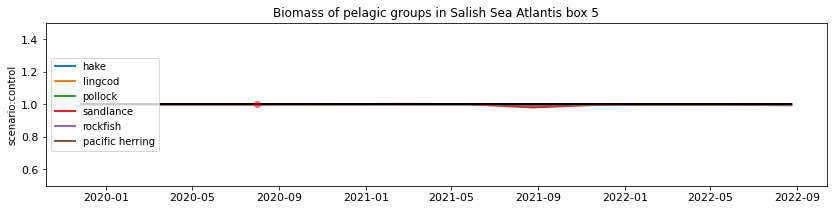

In [119]:
plot_pelagic_box(named_fish, scenario1, 5)

(<Figure size 1008x216 with 1 Axes>,
 <AxesSubplot:title={'center':'Biomass of groups in sediment in Salish Sea Atlantis'}, ylabel='scenario:control'>)

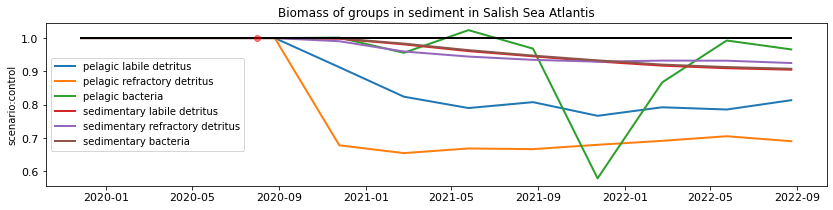

In [144]:
plot_bacteria_box(scenario1, 75)

(<Figure size 1008x216 with 1 Axes>,
 <AxesSubplot:title={'center':'Biomass of groups in sediment in Salish Sea Atlantis'}, ylabel='scenario:control'>)

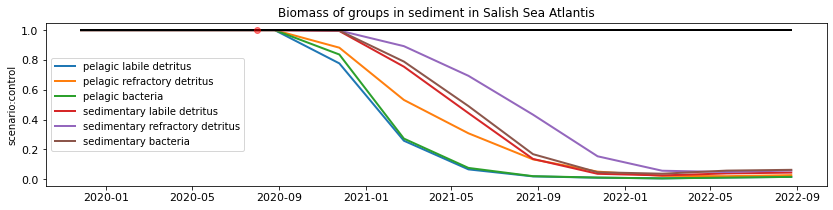

In [139]:
plot_bacteria_box(scenario1, 80)

(<Figure size 1008x216 with 1 Axes>,
 <AxesSubplot:title={'center':'Biomass of groups in sediment in Salish Sea Atlantis'}, ylabel='scenario:control'>)

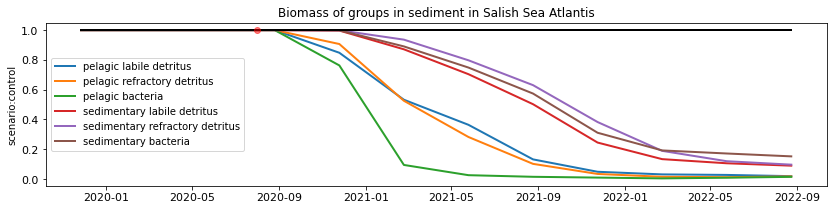

In [141]:
plot_bacteria_box(scenario1, 57)

(<Figure size 1008x216 with 1 Axes>,
 <AxesSubplot:title={'center':'Biomass of groups in sediment in Salish Sea Atlantis'}, ylabel='scenario:control'>)

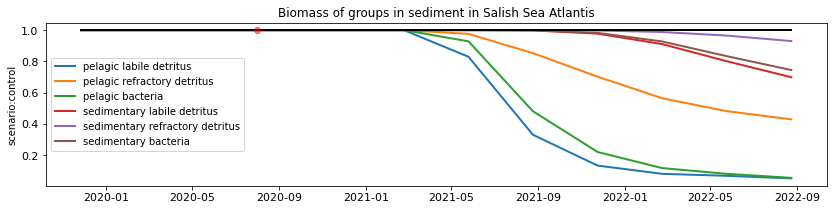

In [145]:
plot_bacteria_box(scenario1, 86) #low discharge

(<Figure size 1008x216 with 1 Axes>,
 <AxesSubplot:title={'center':'Biomass of groups in sediment in Salish Sea Atlantis'}, ylabel='scenario:control'>)

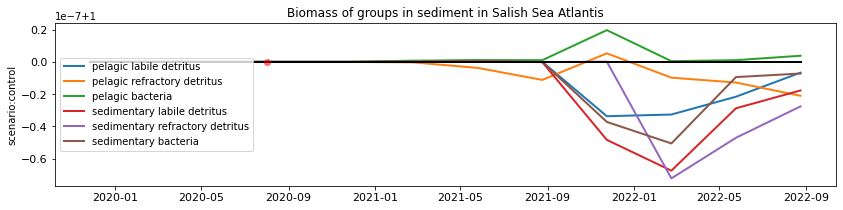

In [146]:
plot_bacteria_box(scenario1, 11) #no direct discharge, US side

### Pelagic cohorts
Chinook_salmon, Chum_salmon, Coho_salmon, Pink_salmon, Sockeye_salmon, Hatchery_Chinook_salmon, Hatchery_Coho_salmon, Hatchery_Sockeye_salmon, Other_salmonids,
Dogfish, Ratfish, Sixgill, Skates, Harbor_porpoise, Harbor_seals, Humpback_whales, Sealions,
Orcas_resident, Orcas_transient, Benthopelagic, Small_pelagic_fish, Small_Demersal_fish, Large_Demersal_fish,
Small_Flatfish, Large_Flatfish, Hake, Lingcod, Pollock, Sandlance, Rockfish, Pacific_herring,
Seabird_gulls, Seabirds

(<Figure size 1008x648 with 3 Axes>,
 array([<AxesSubplot:title={'center':'other seabirds cohort numbers'}, ylabel='scenario : control'>,
        <AxesSubplot:title={'center':'other seabirds cohort structural nitrogen (bone size)'}, ylabel='scenario : control'>,
        <AxesSubplot:title={'center':'other seabirds cohort reserve nitrogen (fatty tissue)'}, ylabel='scenario : control'>],
       dtype=object))

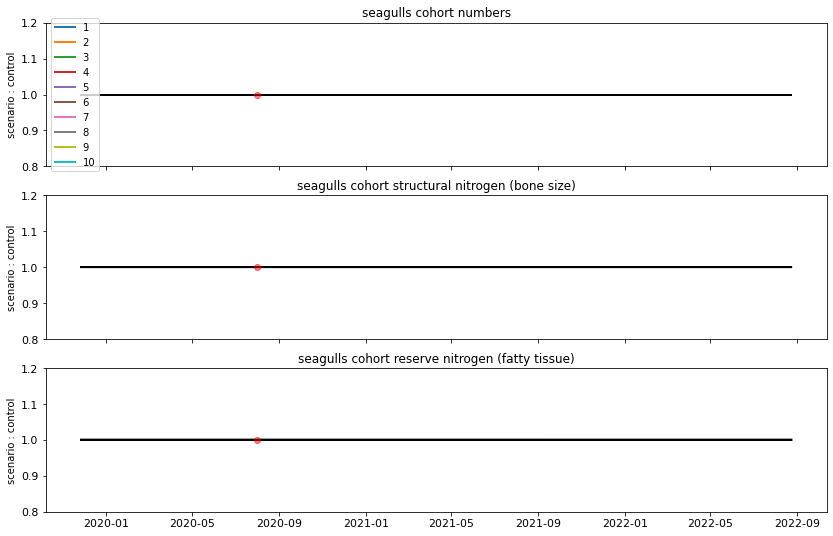

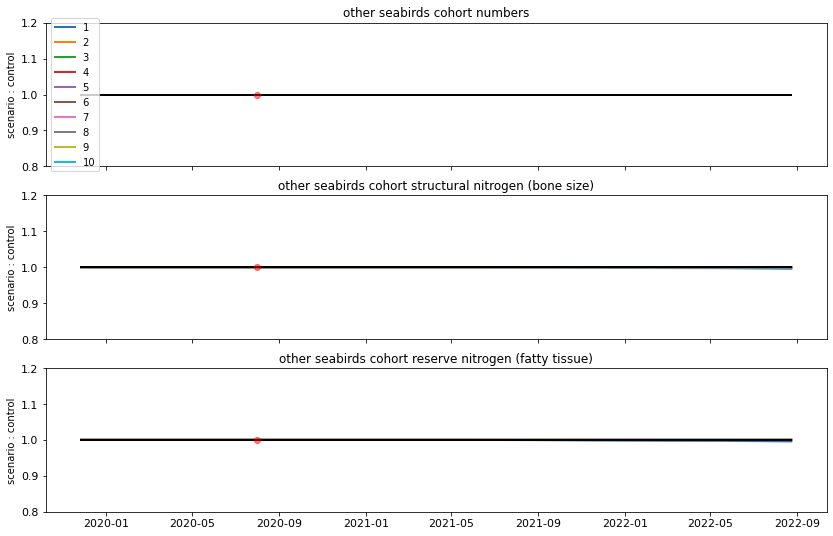

In [48]:
plot_cohorts(birds, scenario1)

(<Figure size 1008x648 with 3 Axes>,
 array([<AxesSubplot:title={'center':'Other cohort numbers'}, ylabel='scenario : control'>,
        <AxesSubplot:title={'center':'Other cohort structural nitrogen (bone size)'}, ylabel='scenario : control'>,
        <AxesSubplot:title={'center':'Other cohort reserve nitrogen (fatty tissue)'}, ylabel='scenario : control'>],
       dtype=object))

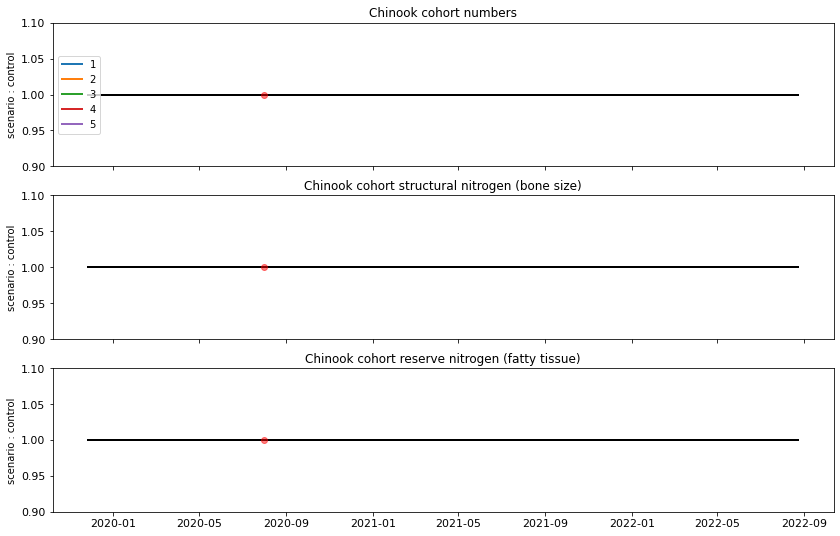

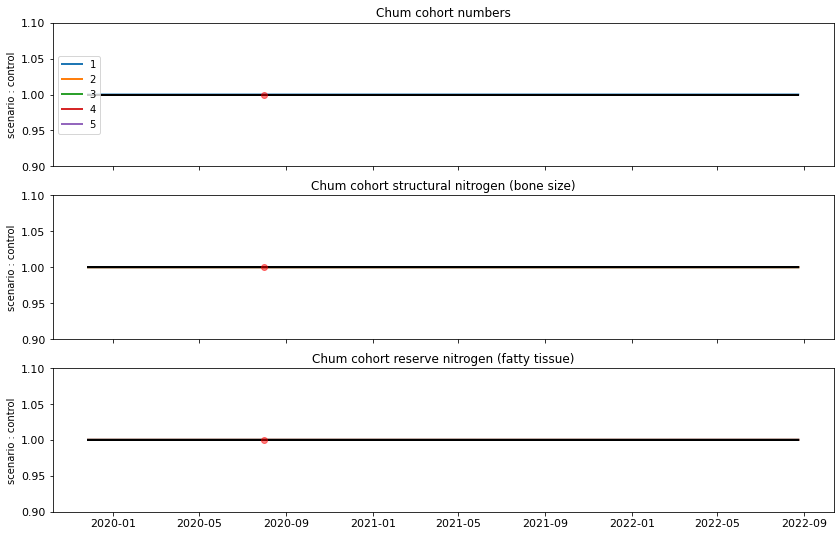

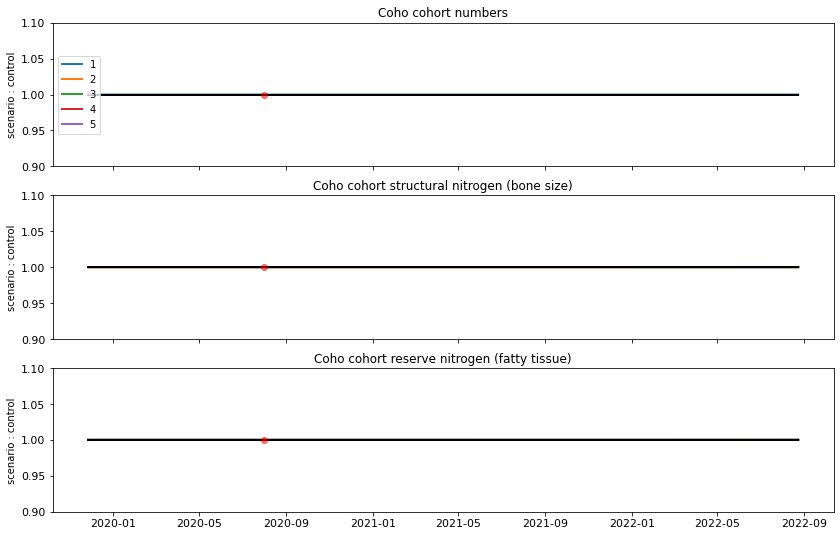

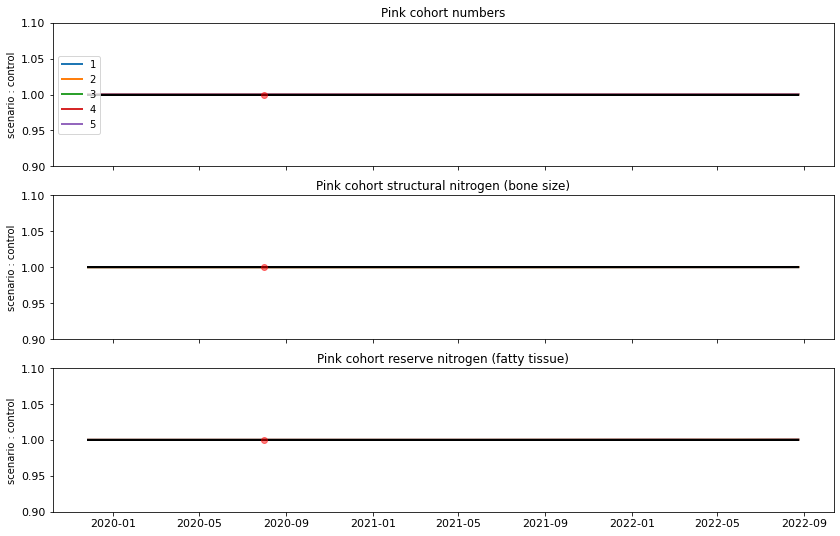

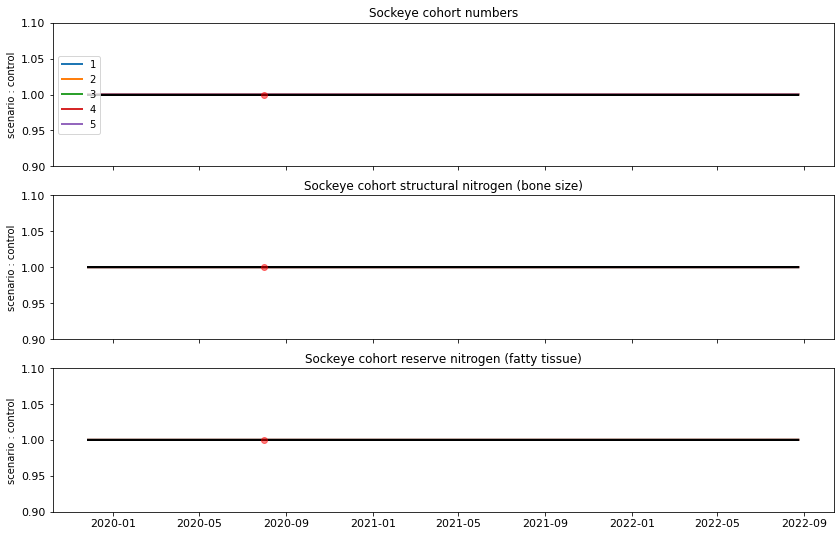

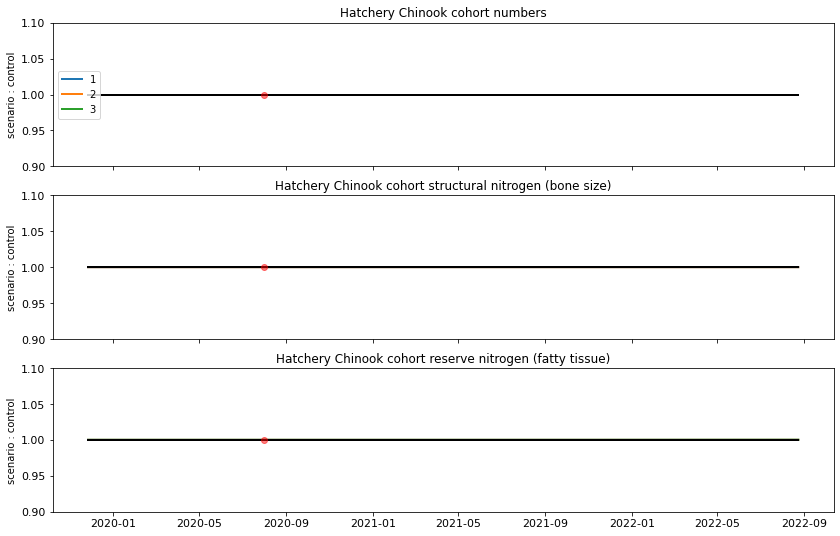

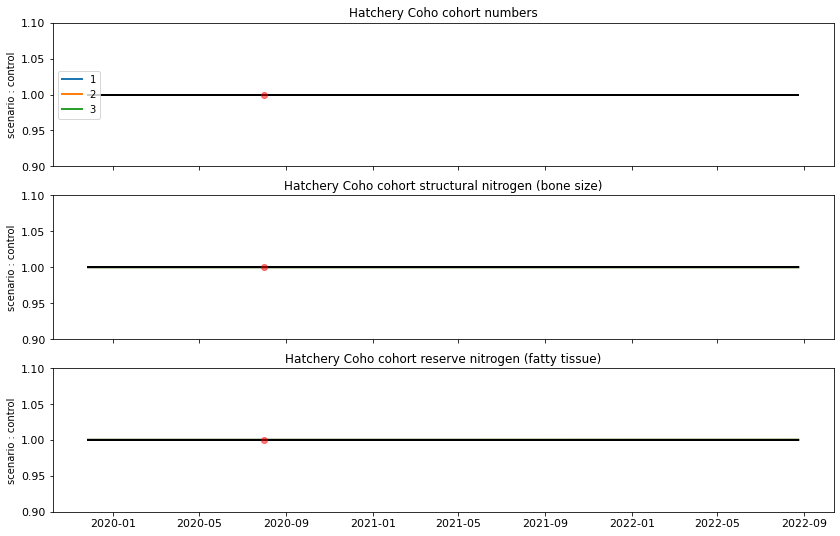

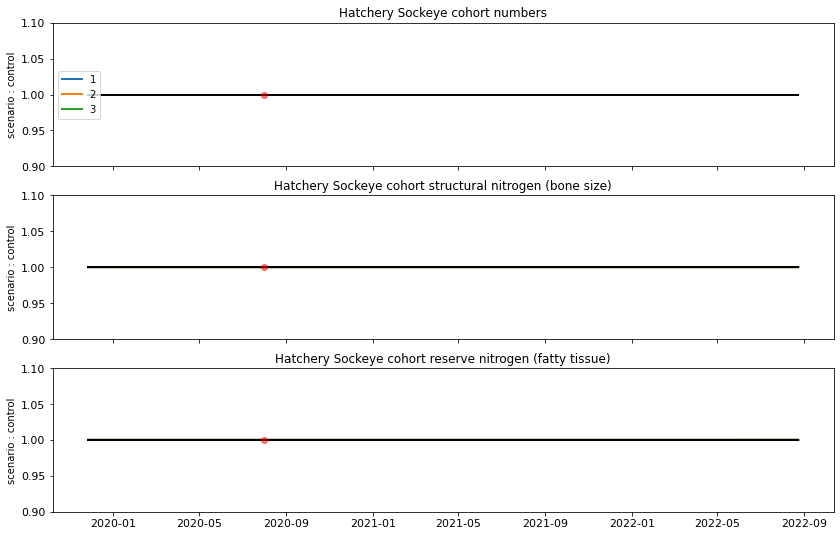

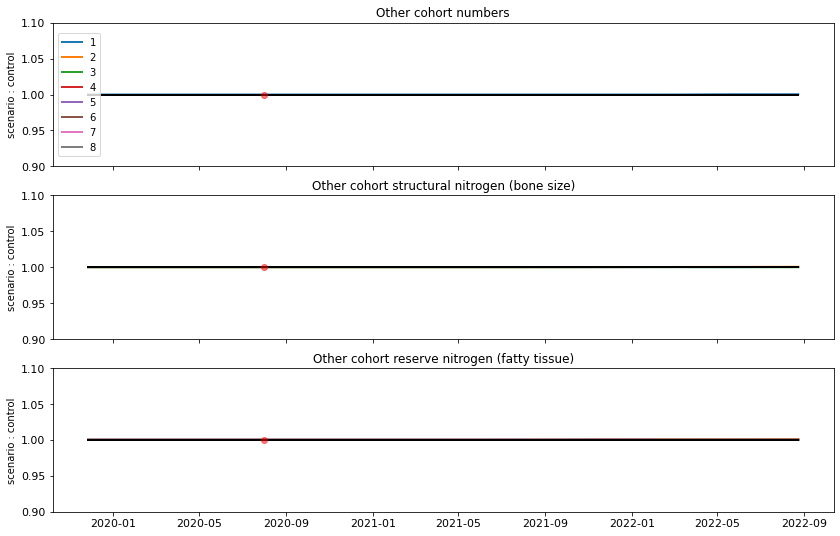

In [50]:
plot_cohorts(salmon, scenario1)

(<Figure size 1008x648 with 3 Axes>,
 array([<AxesSubplot:title={'center':'pacific herring cohort numbers'}, ylabel='scenario : control'>,
        <AxesSubplot:title={'center':'pacific herring cohort structural nitrogen (bone size)'}, ylabel='scenario : control'>,
        <AxesSubplot:title={'center':'pacific herring cohort reserve nitrogen (fatty tissue)'}, ylabel='scenario : control'>],
       dtype=object))

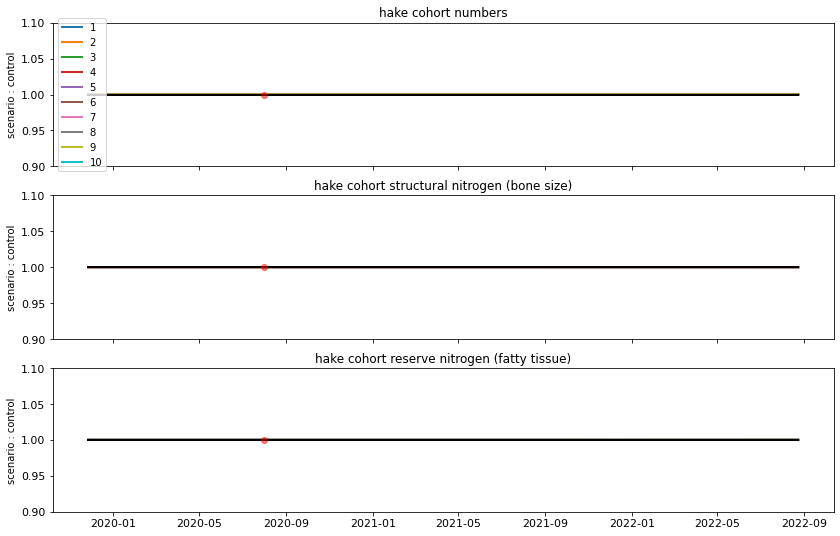

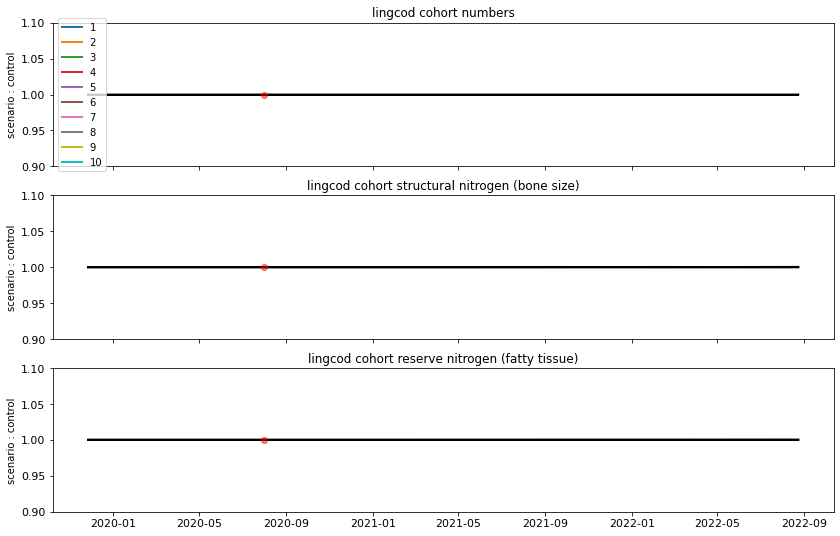

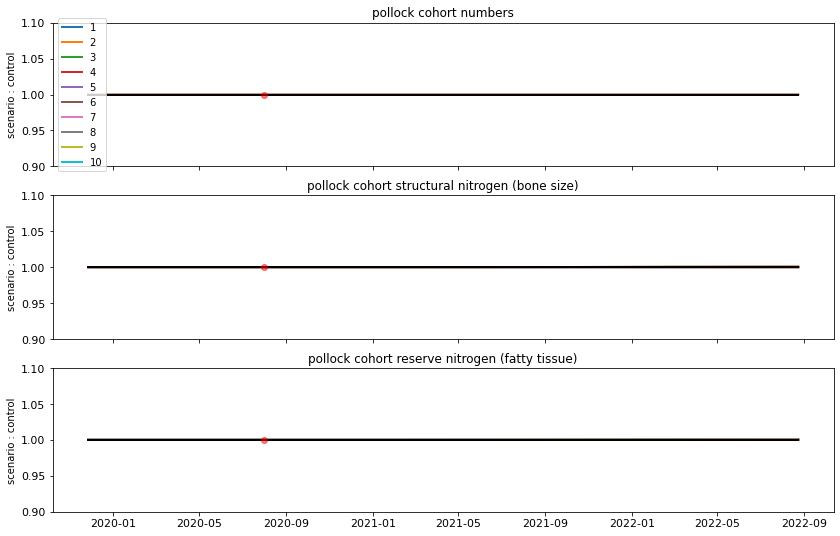

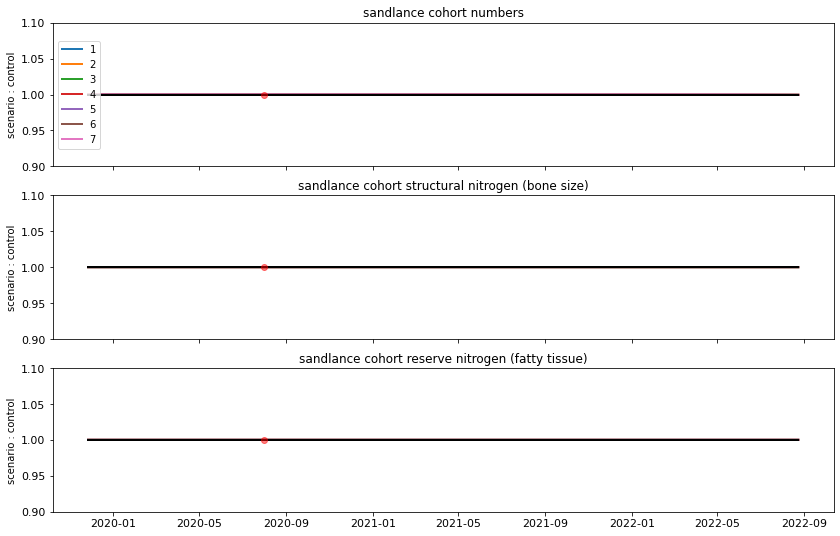

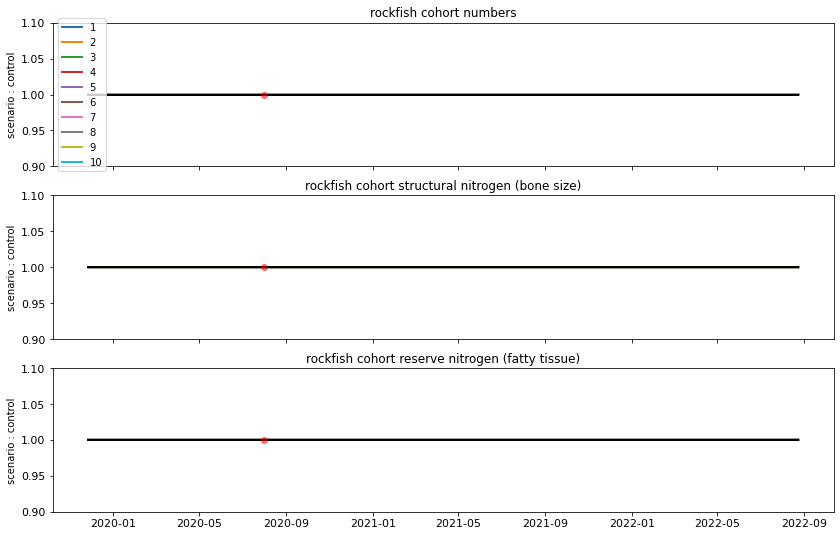

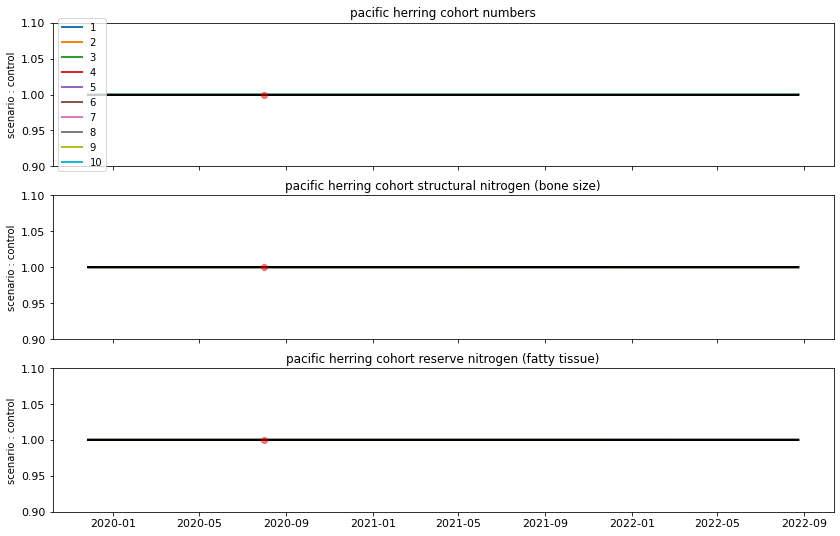

In [52]:
plot_cohorts(named_fish, scenario1)

### Other plots

(<Figure size 1008x216 with 1 Axes>,
 <AxesSubplot:title={'center':'Biomass of pelagic groups across all boxes in Salish Sea Atlantis'}, ylabel='scenario:control'>)

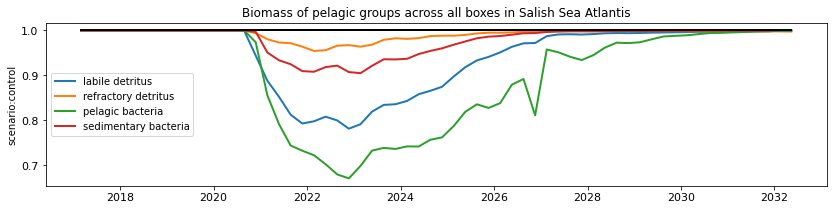

In [25]:
plot_pelagic(bacteria, scenario1)

(<Figure size 1008x216 with 1 Axes>,
 <AxesSubplot:title={'center':'Biomass of pelagic groups across all boxes in Salish Sea Atlantis'}, ylabel='scenario:control'>)

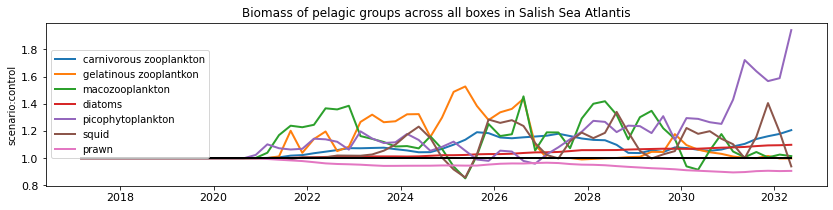

In [26]:
plot_pelagic(plankton, scenario1)

(<Figure size 1008x216 with 1 Axes>,
 <AxesSubplot:title={'center':'Biomass of pelagic groups across all boxes in Salish Sea Atlantis'}, ylabel='scenario:control'>)

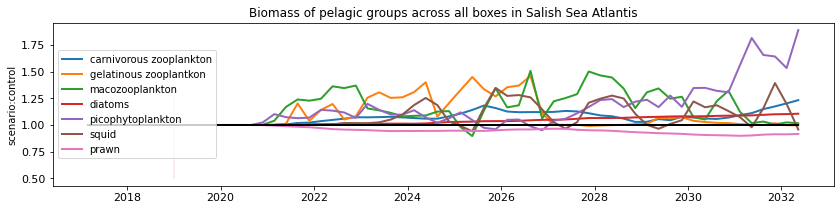

In [31]:
plot_pelagic(plankton, scenario2)

(<Figure size 1008x216 with 1 Axes>,
 <AxesSubplot:title={'center':'Biomass of benthic groups across all boxes in Salish Sea Atlantis'}, ylabel='scenario:control'>)

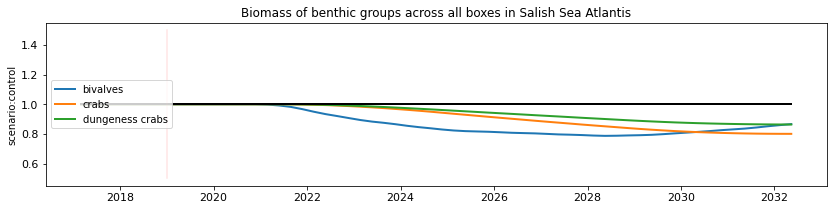

In [32]:
plot_benthic(shellfish, scenario1)

(<Figure size 1008x216 with 1 Axes>,
 <AxesSubplot:title={'center':'Biomass of benthic groups across all boxes in Salish Sea Atlantis'}, ylabel='scenario:control'>)

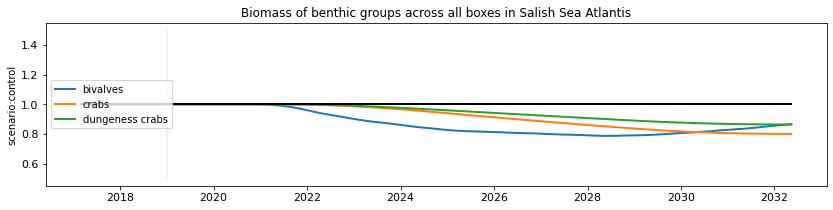

In [33]:
plot_benthic(shellfish, scenario2)

(<Figure size 1008x216 with 1 Axes>,
 <AxesSubplot:title={'center':'Biomass of benthic groups across all boxes in Salish Sea Atlantis'}, ylabel='scenario:control'>)

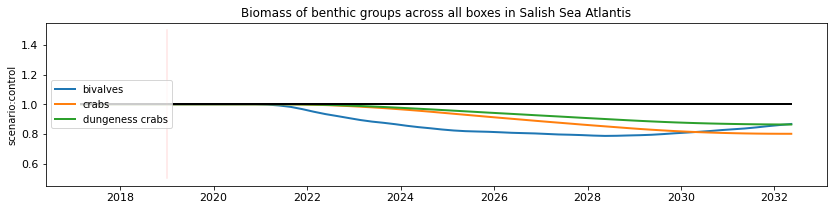

In [34]:
plot_benthic(shellfish, scenario3)

(<Figure size 1008x216 with 1 Axes>,
 <AxesSubplot:title={'center':'Biomass of pelagic groups across all boxes in Salish Sea Atlantis'}, ylabel='scenario:control'>)

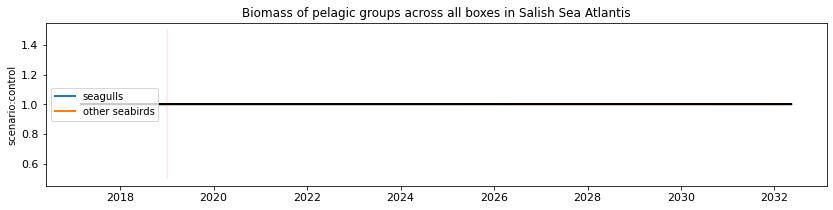

In [39]:
plot_pelagic(birds, scenario2)

(<Figure size 1008x216 with 1 Axes>,
 <AxesSubplot:title={'center':'Biomass of pelagic groups across all boxes in Salish Sea Atlantis'}, ylabel='scenario:control'>)

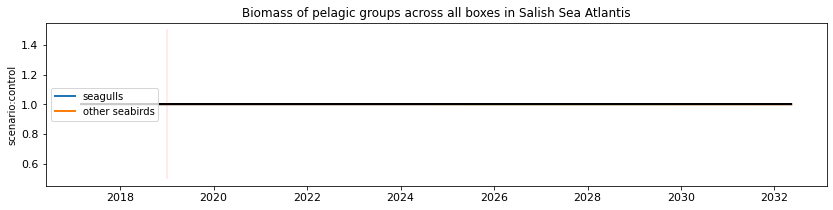

In [40]:
plot_pelagic(birds, scenario3)

(<Figure size 1008x216 with 1 Axes>,
 <AxesSubplot:title={'center':'Phenanthrenein pelagic groups in Salish Sea Atlantis box 75'}, ylabel='mgPAH'>)

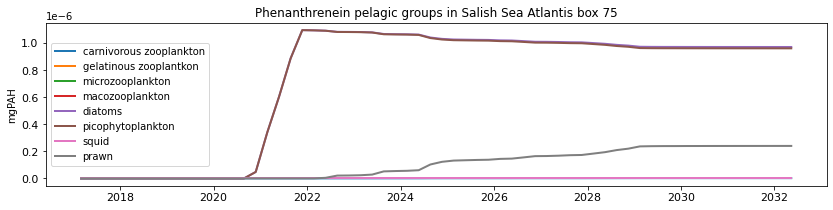

In [39]:
plot_pelagic_pah_box(plankton, 'Phenanthrene', 75) 